In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
transform_withoutNoise=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

**USING GAUSSIAN NOISE**

---



In [ ]:
class GaussianNoise():
    def __init__(self,mean=0.,std=0.25):
        self.mean=mean
        self.std=std

    def __call__(self,tensor):
        return tensor+torch.randn_like(tensor)*self.std+self.mean

transform_gauss=transforms.Compose([
    transforms.ToTensor(),
    GaussianNoise(0.,0.1),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(3,6,5)
        self.pool=nn.MaxPool2d(2,2)
        self.conv2=nn.Conv2d(6,16,5)
        self.fc1=nn.Linear(16*5*5,120)
        self.fc2=nn.Linear(120,84)
        self.fc3=nn.Linear(84,10)

    def forward(self,x):
        x=self.pool(F.relu(self.conv1(x)))
        x=self.pool(F.relu(self.conv2(x)))
        x=torch.flatten(x,1)
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        return x

net = Net()

In [ ]:
batch_size = 32

trainset_clean = torchvision.datasets.CIFAR10(root='./data', train=True, download=True,transform=transform_withoutNoise)
trainloader_clean = torch.utils.data.DataLoader(trainset_clean, batch_size=batch_size,shuffle=True)
testset_clean = torchvision.datasets.CIFAR10(root='./data', train=False, download=True,transform=transform_withoutNoise)
testloader_clean = torch.utils.data.DataLoader(testset_clean, batch_size=batch_size,shuffle=False)

trainset_gauss = torchvision.datasets.CIFAR10(root='./data', train=True, download=True,transform=transform_gauss)
trainloader_gauss = torch.utils.data.DataLoader(trainset_gauss, batch_size=batch_size,shuffle=True)
testset_gauss = torchvision.datasets.CIFAR10(root='./data', train=False, download=True,transform=transform_gauss)
testloader_gauss = torch.utils.data.DataLoader(testset_gauss, batch_size=batch_size,shuffle=False)

In [ ]:
from torch.utils.data import random_split

train_size=int(0.8*len(trainset_clean))
val_size=len(trainset_clean)-train_size

trainset_clean_split,valset_clean=random_split(trainset_clean,[train_size,val_size])
trainloader_clean=torch.utils.data.DataLoader(trainset_clean_split,batch_size=batch_size,shuffle=True)
valloader_clean=torch.utils.data.DataLoader(valset_clean,batch_size=batch_size,shuffle=False)

trainset_gauss_split,valset_gauss=random_split(trainset_gauss,[train_size,val_size])
trainloader_gauss=torch.utils.data.DataLoader(trainset_gauss_split,batch_size=batch_size,shuffle=True)
valloader_gauss=torch.utils.data.DataLoader(valset_gauss,batch_size=batch_size,shuffle=False)

In [ ]:
print(len(trainset_clean))
print(len(trainset_clean_split))
print(len(valset_clean))
print(len(trainset_gauss))
print(len(testset_clean))
print(len(testset_gauss))

50000
40000
10000
50000
10000
10000


In [ ]:
def run_experiment(model,trainloader,valloader,num_epochs=10,tag=""):
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model=model.to(device)
    optimizer=torch.optim.Adam(model.parameters(),lr=0.001)
    criterion=nn.CrossEntropyLoss()

    train_losses,val_losses,train_accs,val_accs=[],[],[],[]

    for epoch in range(num_epochs):
        model.train()
        running_loss,correct,total=0.0,0,0
        for inputs,labels in trainloader: # input [batch_size,channels,height,width] (tensor)
            inputs,labels=inputs.to(device),labels.to(device)
            optimizer.zero_grad()
            outputs=model(inputs)
            loss=criterion(outputs,labels)
            loss.backward()
            optimizer.step()

            running_loss+=loss.item()
            _, predicted=torch.max(outputs,1)
            total+=labels.size(0)
            correct+=(predicted==labels).sum().item()

        train_losses.append(running_loss/len(trainloader))
        train_accs.append(100*correct/total)

        model.eval()
        val_loss,correct,total=0.0,0,0
        with torch.no_grad():
            for inputs,labels in valloader:
                inputs,labels=inputs.to(device),labels.to(device)
                outputs=model(inputs)
                loss=criterion(outputs,labels)
                val_loss+=loss.item()
                _, predicted=torch.max(outputs, 1)
                total+=labels.size(0)
                correct+=(predicted==labels).sum().item()

        val_losses.append(val_loss/len(valloader))
        val_accs.append(100*correct/total)
        print(f"[{tag}] Epoch {epoch+1}: Train Acc={train_accs[-1]:.2f}%, Val Acc={val_accs[-1]:.2f}%")

    return train_losses,val_losses,train_accs,val_accs

In [ ]:
results={}

model_clean=Net()
results["Without Noise"]=run_experiment(model_clean,trainloader_clean,valloader_clean,num_epochs=5,tag="Without Noise")

model_noise=Net()
results["Gaussian Noise"]=run_experiment(model_noise,trainloader_gauss,valloader_gauss,num_epochs=5,tag="Gaussian Noise")

[Without Noise] Epoch 1: Train Acc=39.74%, Val Acc=47.95%
[Without Noise] Epoch 2: Train Acc=51.43%, Val Acc=52.96%
[Without Noise] Epoch 3: Train Acc=56.33%, Val Acc=55.21%
[Without Noise] Epoch 4: Train Acc=59.45%, Val Acc=58.56%
[Without Noise] Epoch 5: Train Acc=61.41%, Val Acc=58.89%
[Gaussian Noise] Epoch 1: Train Acc=38.80%, Val Acc=47.99%
[Gaussian Noise] Epoch 2: Train Acc=49.92%, Val Acc=52.70%
[Gaussian Noise] Epoch 3: Train Acc=53.89%, Val Acc=52.53%
[Gaussian Noise] Epoch 4: Train Acc=56.87%, Val Acc=54.65%
[Gaussian Noise] Epoch 5: Train Acc=58.83%, Val Acc=57.19%


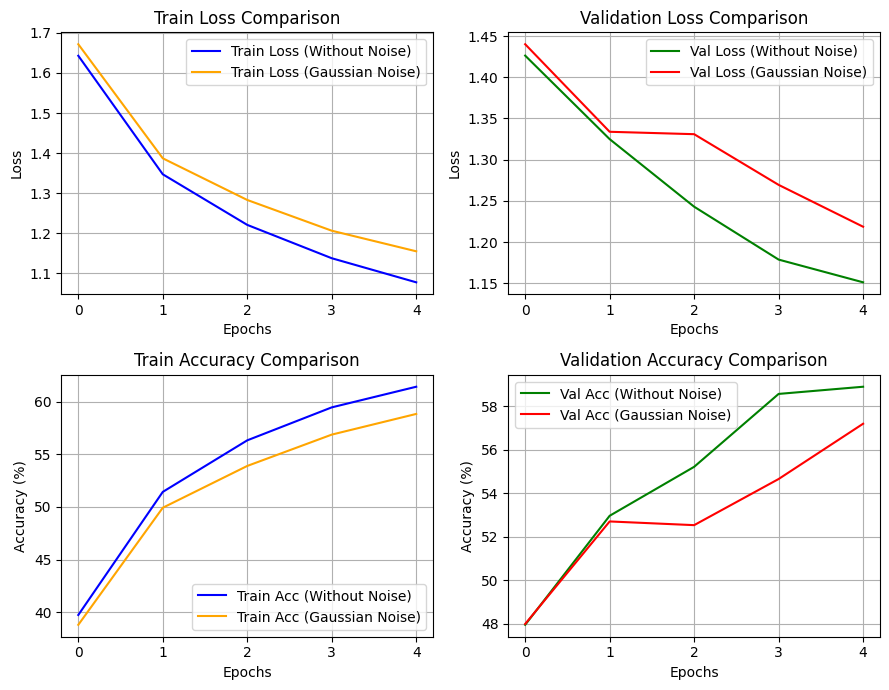

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(9,7))

# Train Loss Comparison
plt.subplot(2,2,1)
plt.plot(results["Without Noise"][0], label="Train Loss (Without Noise)", color='blue')
plt.plot(results["Gaussian Noise"][0], label="Train Loss (Gaussian Noise)", color='orange')
plt.title("Train Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Validation Loss Comparison
plt.subplot(2,2,2)
plt.plot(results["Without Noise"][1], label="Val Loss (Without Noise)", color='green')
plt.plot(results["Gaussian Noise"][1], label="Val Loss (Gaussian Noise)", color='red')
plt.title("Validation Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Train Accuracy Comparison
plt.subplot(2,2,3)
plt.plot(results["Without Noise"][2], label="Train Acc (Without Noise)", color='blue')
plt.plot(results["Gaussian Noise"][2], label="Train Acc (Gaussian Noise)", color='orange')
plt.title("Train Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

# Validation Accuracy Comparison
plt.subplot(2,2,4)
plt.plot(results["Without Noise"][3], label="Val Acc (Without Noise)", color='green')
plt.plot(results["Gaussian Noise"][3], label="Val Acc (Gaussian Noise)", color='red')
plt.title("Validation Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
import torch

device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
def evaluate_test(model,testloader,criterion,device):
    model.eval()
    test_loss=0.0
    correct,total=0,0

    with torch.no_grad():
        for inputs,labels in testloader:
            inputs,labels=inputs.to(device),labels.to(device)
            outputs=model(inputs)
            loss=criterion(outputs,labels)
            test_loss+=loss.item()
            _, predicted=outputs.max(1)
            total+=labels.size(0)
            correct+=predicted.eq(labels).sum().item()

    avg_test_loss=test_loss/len(testloader)
    test_accuracy=correct/total*100
    return avg_test_loss,test_accuracy

In [ ]:
criterion = nn.CrossEntropyLoss()
test_loss_withoutNoise, test_acc_withoutNoise = evaluate_test(model_clean, testloader_clean, criterion, device)
test_loss_gauss, test_acc_gauss = evaluate_test(model_noise, testloader_gauss, criterion, device)

results["Clean_Test"] = [test_loss_withoutNoise, test_acc_withoutNoise]
results["Gaussian_Test"] = [test_loss_gauss, test_acc_gauss]

In [ ]:
print(f"Final Test Loss (Without Noise): {results['Clean_Test'][0]:.4f}")
print(f"Final Test Accuracy (Without Noise): {results['Clean_Test'][1]:.2f}%")

print(f"Final Test Loss (Gaussian Noise): {results['Gaussian_Test'][0]:.4f}")
print(f"Final Test Accuracy (Gaussian Noise): {results['Gaussian_Test'][1]:.2f}%")

Final Test Loss (Without Noise): 1.1452
Final Test Accuracy (Without Noise): 59.32%
Final Test Loss (Gaussian Noise): 1.2201
Final Test Accuracy (Gaussian Noise): 56.66%


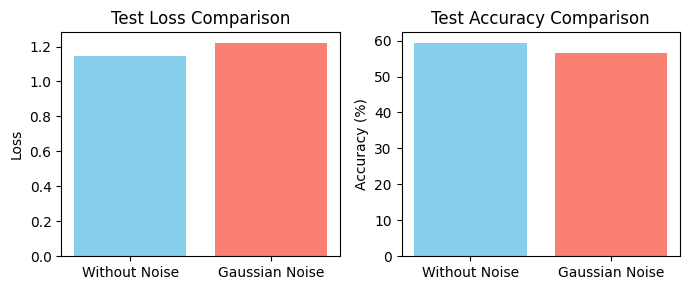

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,3))

plt.subplot(1,2,1)
plt.bar(["Without Noise", "Gaussian Noise"], [results["Clean_Test"][0], results["Gaussian_Test"][0]], color=['skyblue', 'salmon'])
plt.title("Test Loss Comparison")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.bar(["Without Noise", "Gaussian Noise"], [results["Clean_Test"][1], results["Gaussian_Test"][1]], color=['skyblue', 'salmon'])
plt.title("Test Accuracy Comparison")
plt.ylabel("Accuracy (%)")

plt.tight_layout()
plt.show()

**USING ACTIVATION NOISE**

---



In [ ]:
class ActivationNoise(nn.Module):
    def __init__(self,std=0.35):
        super().__init__()
        self.std=std

    def forward(self,x):
        if self.training:
            noise=torch.randn_like(x)*self.std
            return x+noise
        return x

In [ ]:
class Net_ActivationNoise(nn.Module):
    def __init__(self,noise_std=0.35):
        super().__init__()
        self.conv1=nn.Conv2d(3,6,5)
        self.pool=nn.MaxPool2d(2,2)
        self.conv2=nn.Conv2d(6,16,5)
        self.fc1=nn.Linear(16*5*5,120)
        self.fc2=nn.Linear(120,84)
        self.fc3=nn.Linear(84,10)

        self.noise = ActivationNoise(std=noise_std)

    def forward(self,x):
        x=self.pool(F.relu(self.conv1(x)))
        x=self.noise(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.noise(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.noise(x)
        x = F.relu(self.fc2(x))
        x = self.noise(x)
        x = self.fc3(x)
        return x

In [ ]:
results = {}

model_clean=Net()
results["Without Noise"]=run_experiment(model_clean,trainloader_clean,valloader_clean,num_epochs=5,tag="Without Noise")

model_noise=Net_ActivationNoise()
results["Activation Noise"]=run_experiment(model_noise,trainloader_clean,valloader_clean,num_epochs=5,tag="Activation Noise")

[Without Noise] Epoch 1: Train Acc=39.91%, Val Acc=46.99%
[Without Noise] Epoch 2: Train Acc=51.39%, Val Acc=53.18%
[Without Noise] Epoch 3: Train Acc=56.40%, Val Acc=55.89%
[Without Noise] Epoch 4: Train Acc=59.58%, Val Acc=57.94%
[Without Noise] Epoch 5: Train Acc=62.16%, Val Acc=60.49%
[Activation Noise] Epoch 1: Train Acc=36.37%, Val Acc=47.06%
[Activation Noise] Epoch 2: Train Acc=47.32%, Val Acc=51.18%
[Activation Noise] Epoch 3: Train Acc=51.41%, Val Acc=53.07%
[Activation Noise] Epoch 4: Train Acc=54.21%, Val Acc=53.23%
[Activation Noise] Epoch 5: Train Acc=56.38%, Val Acc=56.54%


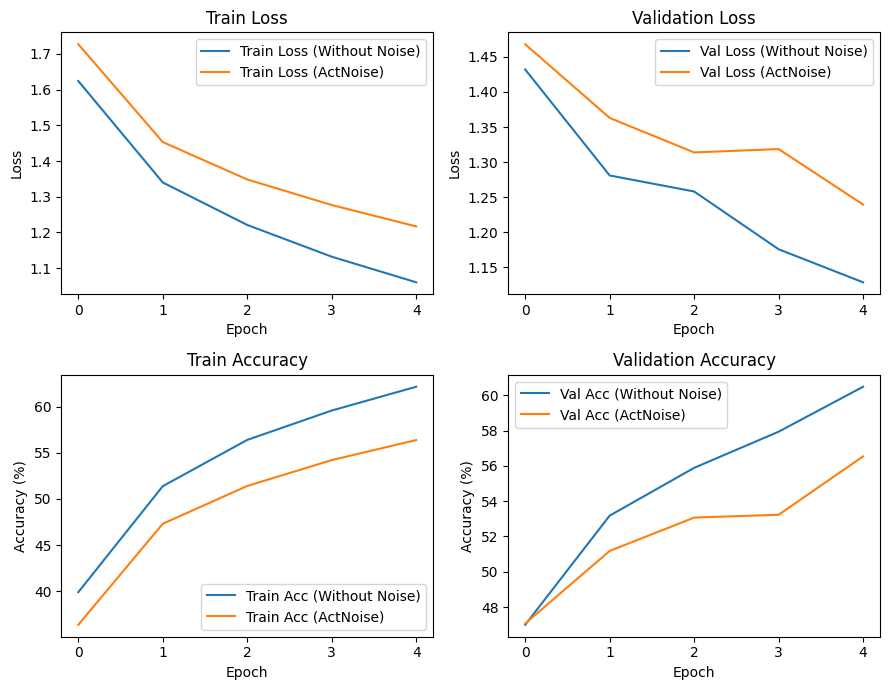

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(9,7))

# Train Loss
plt.subplot(2,2,1)
plt.plot(results["Without Noise"][0], label="Train Loss (Without Noise)")
plt.plot(results["Activation Noise"][0], label="Train Loss (ActNoise)")
plt.title("Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Val Loss
plt.subplot(2,2,2)
plt.plot(results["Without Noise"][1], label="Val Loss (Without Noise)")
plt.plot(results["Activation Noise"][1], label="Val Loss (ActNoise)")
plt.title("Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Train Accuracy
plt.subplot(2,2,3)
plt.plot(results["Without Noise"][2], label="Train Acc (Without Noise)")
plt.plot(results["Activation Noise"][2], label="Train Acc (ActNoise)")
plt.title("Train Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

# Val Accuracy
plt.subplot(2,2,4)
plt.plot(results["Without Noise"][3], label="Val Acc (Without Noise)")
plt.plot(results["Activation Noise"][3], label="Val Acc (ActNoise)")
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
criterion = nn.CrossEntropyLoss()
test_loss_withoutNoise, test_acc_withoutNoise = evaluate_test(model_clean, testloader_clean, criterion, device)
test_loss_act, test_acc_act = evaluate_test(model_noise, testloader_clean, criterion, device)

results["Clean_Test"] = [test_loss_withoutNoise, test_acc_withoutNoise]
results["Activation_Test"] = [test_loss_act, test_acc_act]

In [ ]:
print(f"Final Test Loss (Without Noise): {results['Clean_Test'][0]:.4f}")
print(f"Final Test Accuracy (Without Noise): {results['Clean_Test'][1]:.2f}%")

print(f"Final Test Loss (Activation Noise): {results['Activation_Test'][0]:.4f}")
print(f"Final Test Accuracy (Activation Noise): {results['Activation_Test'][1]:.2f}%")

Final Test Loss (Without Noise): 1.1273
Final Test Accuracy (Without Noise): 60.27%
Final Test Loss (Activation Noise): 1.2191
Final Test Accuracy (Activation Noise): 56.72%


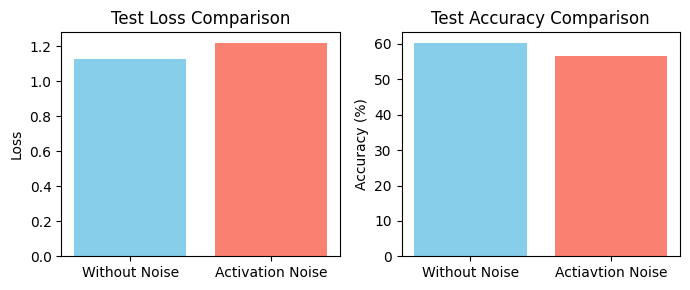

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7,3))

plt.subplot(1,2,1)
plt.bar(["Without Noise", "Activation Noise"], [results["Clean_Test"][0], results["Activation_Test"][0]], color=['skyblue', 'salmon'])
plt.title("Test Loss Comparison")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.bar(["Without Noise", "Actiavtion Noise"], [results["Clean_Test"][1], results["Activation_Test"][1]], color=['skyblue', 'salmon'])
plt.title("Test Accuracy Comparison")
plt.ylabel("Accuracy (%)")

plt.tight_layout()
plt.show()